In [1]:
import torch
from torchvision import datasets, transforms

# define a transform (convert to tensor & normalize to [0,1])
transform = transforms.Compose([
    transforms.ToTensor()
])

# download & load training dataset
train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

# extract images and labels (tensors)
trainX = train_dataset.data
trainy = train_dataset.targets
testX = test_dataset.data
testy = test_dataset.targets

# summarize the shape of the dataset
print('Train', trainX.shape, trainy.shape)
print('Test', testX.shape, testy.shape)


100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 483kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.47MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.03MB/s]

Train torch.Size([60000, 28, 28]) torch.Size([60000])
Test torch.Size([10000, 28, 28]) torch.Size([10000])


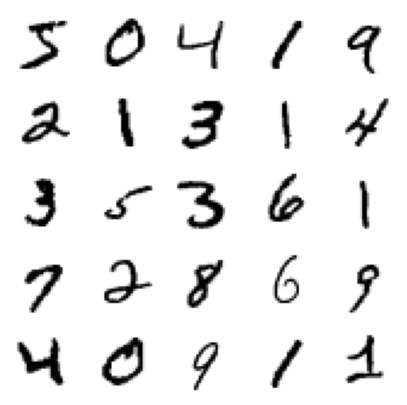

In [2]:
import matplotlib.pyplot as plt
# get raw image data (28x28 grayscale images)
images = train_dataset.data
labels = train_dataset.targets

# plot first 25 images (5x5 grid)
plt.figure(figsize=(5,5))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.axis('off')
    plt.imshow(images[i], cmap='gray_r')  # gray_r = white digits on black background
plt.show()

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


class Generator(nn.Module):
    def __init__(self, z_dim, img_dim):
        super().__init__()
        self.gen = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.LeakyReLU(0.01),
            nn.Linear(256, img_dim),
            nn.Tanh(),  # normalize inputs to [-1, 1] so make outputs [-1, 1]
        )

    def forward(self, x):
        return self.gen(x)

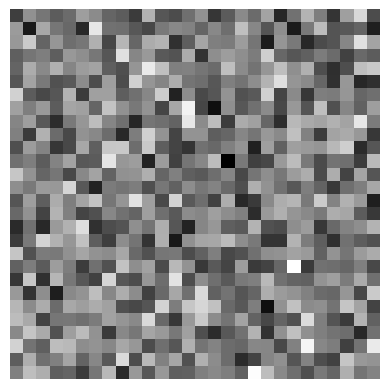

In [7]:
z_dim = 64
image_dim = 28*28

# initialize generator
gen = Generator(z_dim, image_dim).eval()

# sample random noise
z = torch.randn(1, z_dim)  # batch=1

# generate fake image
with torch.no_grad():
    fake = gen(z).reshape(28, 28).cpu()  # reshape to (28,28)

# plot
plt.imshow(fake, cmap="gray")
plt.axis("off")
plt.show()



In [8]:
class Discriminator(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.LeakyReLU(0.01),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.disc(x)


Epoch [0/20] Batch 0/1875 Loss D: 0.7425, Loss G: 0.6878


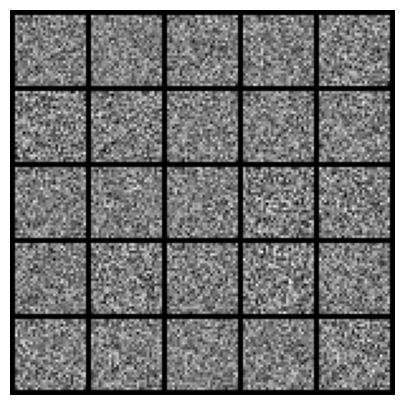

Epoch [1/20] Batch 0/1875 Loss D: 0.3225, Loss G: 1.5570


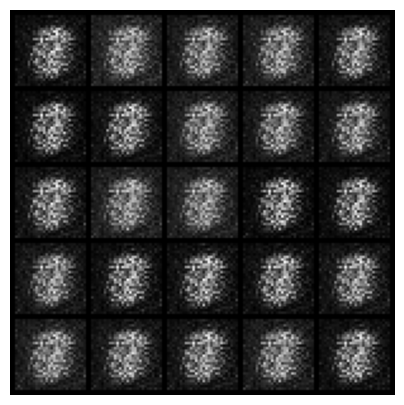

Epoch [2/20] Batch 0/1875 Loss D: 0.5086, Loss G: 0.9727


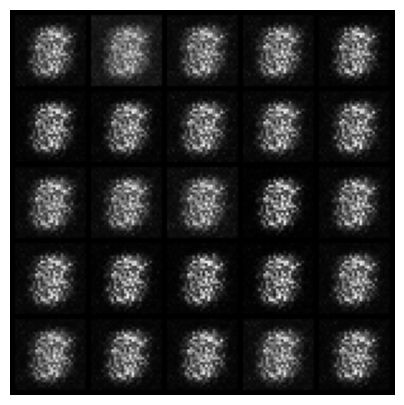

Epoch [3/20] Batch 0/1875 Loss D: 0.1859, Loss G: 1.9337


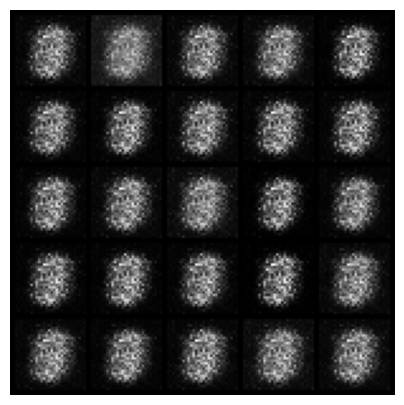

Epoch [4/20] Batch 0/1875 Loss D: 0.6167, Loss G: 0.9670


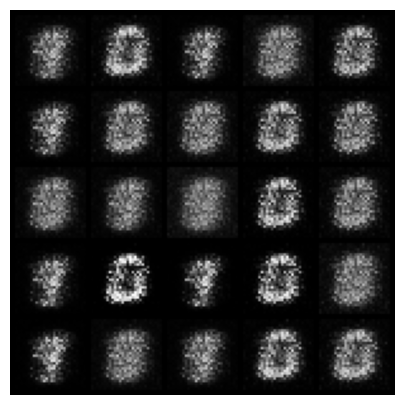

Epoch [5/20] Batch 0/1875 Loss D: 0.7890, Loss G: 0.8357


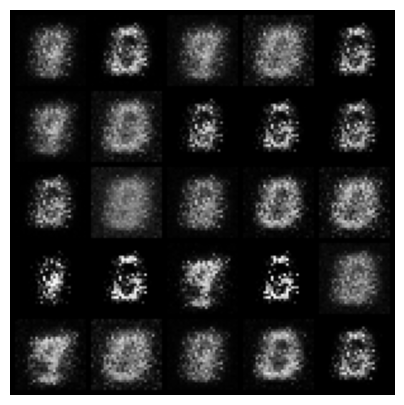

Epoch [6/20] Batch 0/1875 Loss D: 0.7835, Loss G: 0.8711


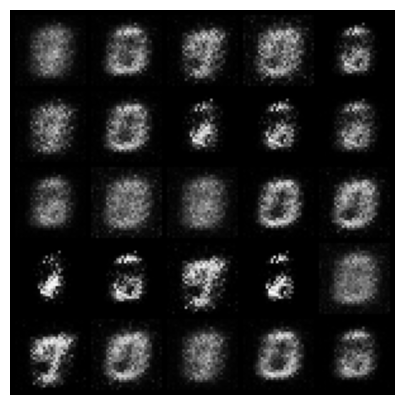

Epoch [7/20] Batch 0/1875 Loss D: 0.3900, Loss G: 1.5924


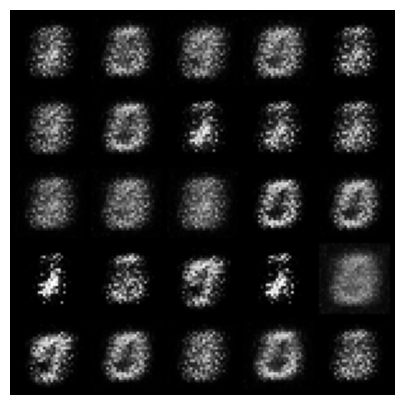

Epoch [8/20] Batch 0/1875 Loss D: 0.6197, Loss G: 1.0142


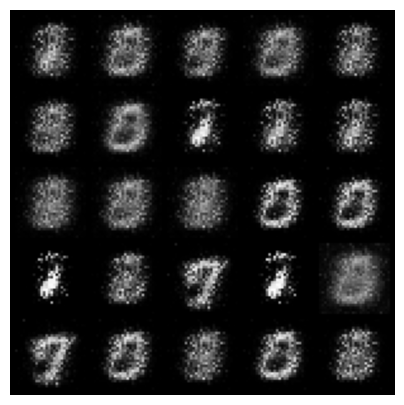

Epoch [9/20] Batch 0/1875 Loss D: 0.7550, Loss G: 1.1126


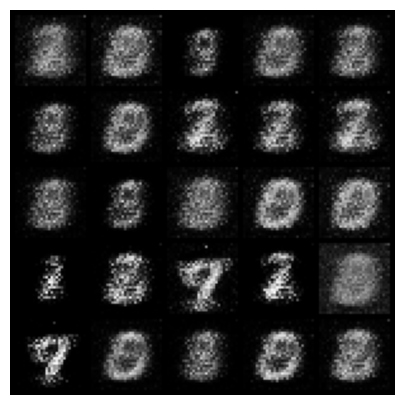

Epoch [10/20] Batch 0/1875 Loss D: 0.6929, Loss G: 1.0919


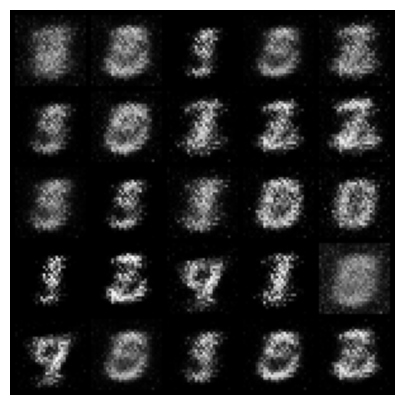

Epoch [11/20] Batch 0/1875 Loss D: 0.4853, Loss G: 1.5125


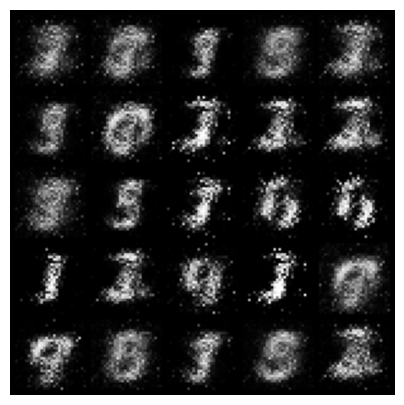

Epoch [12/20] Batch 0/1875 Loss D: 0.6352, Loss G: 1.1326


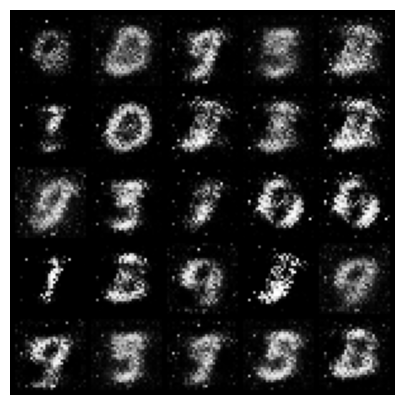

Epoch [13/20] Batch 0/1875 Loss D: 0.5728, Loss G: 1.0389


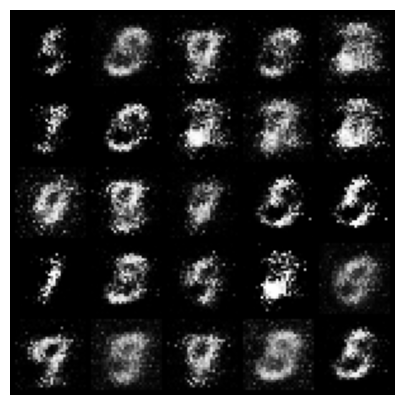

Epoch [14/20] Batch 0/1875 Loss D: 0.6968, Loss G: 0.9362


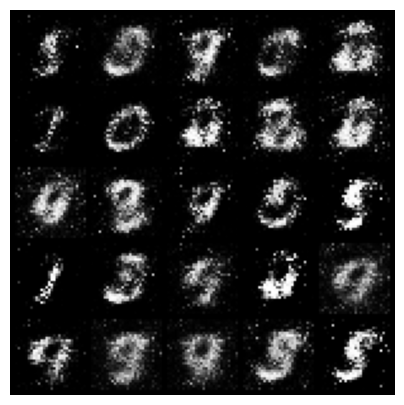

Epoch [15/20] Batch 0/1875 Loss D: 0.3409, Loss G: 1.9660


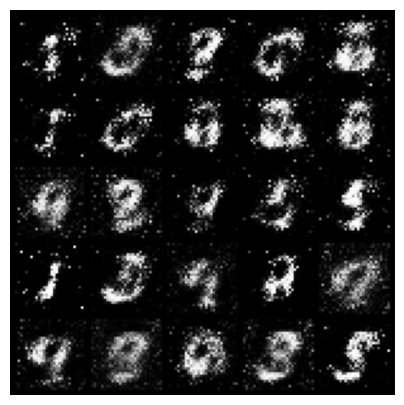

Epoch [16/20] Batch 0/1875 Loss D: 0.7253, Loss G: 1.2210


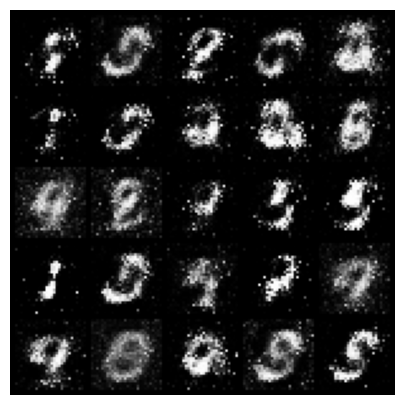

Epoch [17/20] Batch 0/1875 Loss D: 0.4961, Loss G: 1.3955


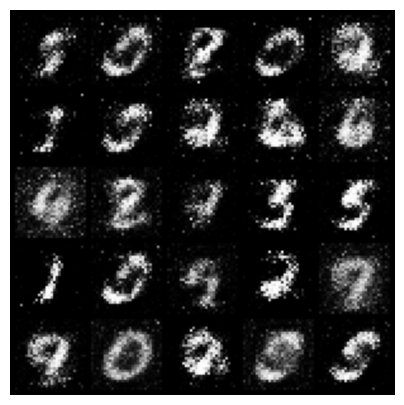

Epoch [18/20] Batch 0/1875 Loss D: 0.3715, Loss G: 2.1226


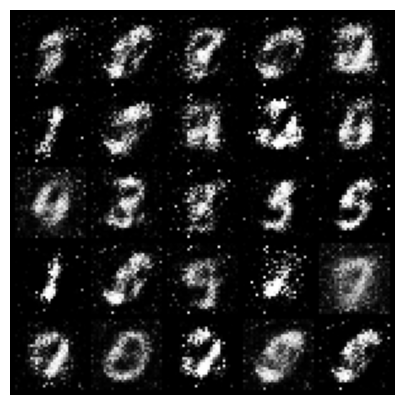

Epoch [19/20] Batch 0/1875 Loss D: 0.7680, Loss G: 1.3658


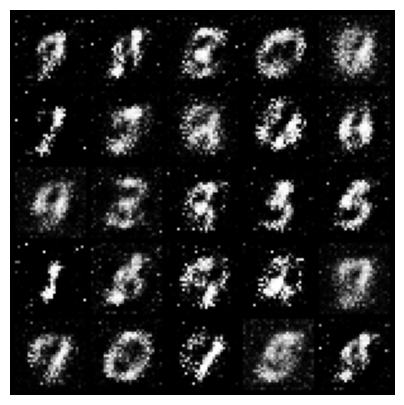

In [12]:
# Hyperparameters
device = "cuda" if torch.cuda.is_available() else "cpu"
lr = 3e-4
z_dim = 64
image_dim = 28 * 28 * 1
batch_size = 32
num_epochs = 20

disc = Discriminator(image_dim).to(device)
gen = Generator(z_dim, image_dim).to(device)
fixed_noise = torch.randn((batch_size, z_dim)).to(device)

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

dataset = datasets.MNIST(root="dataset/", transform=transform, download=True)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
opt_disc = optim.Adam(disc.parameters(), lr=lr)
opt_gen = optim.Adam(gen.parameters(), lr=lr)
criterion = nn.BCELoss()

step = 0

for epoch in range(num_epochs):
    for batch_idx, (real, _) in enumerate(loader):
        real = real.view(-1, 784).to(device)
        batch_size = real.shape[0]

        ### Train Discriminator
        noise = torch.randn(batch_size, z_dim).to(device)
        fake = gen(noise)
        disc_real = disc(real).view(-1)
        lossD_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake).view(-1)
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        lossD = (lossD_real + lossD_fake) / 2
        disc.zero_grad()
        lossD.backward(retain_graph=True)
        opt_disc.step()

        ### Train Generator
        output = disc(fake).view(-1)
        lossG = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        lossG.backward()
        opt_gen.step()

        if batch_idx == 0:
            print(
                f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(loader)} "
                f"Loss D: {lossD:.4f}, Loss G: {lossG:.4f}"
            )

            #  Plot generated images
            with torch.no_grad():
                fake = gen(fixed_noise).reshape(-1, 1, 28, 28).cpu()
                grid = torchvision.utils.make_grid(fake[:25], nrow=5, normalize=True)

                plt.figure(figsize=(5,5))
                plt.axis("off")
                plt.imshow(grid.permute(1, 2, 0))  # (C,H,W) -> (H,W,C)
                plt.show()
            
            step += 1